## Dependencies

In [1]:
import time, os, pickle, json
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from random import choice
from os.path import join as pjoin

In [2]:
def axis_off(mode=2):
    if mode==2:
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    elif mode==3:
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])

## Stage 1 data preparation
### 1. file names

In [3]:
# path preparation
Analysis_path = '/nfs/s2/userhome/gongzhengxin/nvd/Analysis_results'
data_path = pjoin(Analysis_path, 'imagenet_decoding')

# class-superclass file
superclassfile = 'superClassMapping.csv'
# roi atlas
atlasfile = 'MMP_mpmLR32k.mat'
atlas_namefile = 'roilbl_mmp.csv'
# animation label
animatefile = 'animate_or_not.mat'
# subject list
subjects = ['sub-core02', 'sub-core03']

### 2. imagenet preparation
then we convert the imagename in .pkl to 30 classes and we save out the label into **subject_label.npy**


In [8]:
# super class mapping 
class_mapping = pd.read_csv(pjoin(Analysis_path, superclassfile))
class_mapping.head()

classID  superClassID          className superClassName
0  n01440764             5              tench           fish
1  n01443537             5           goldfish           fish
2  n01484850             5  great white shark           fish
3  n01491361             5        tiger shark           fish
4  n01494475             5         hammerhead           fish

In [31]:
# convertion into 30 superclass and save out 
for subject in subjects:
    images_name_file = '_'.join([subject, 'imagenet-response.pkl'])
    # 
    labels = []
    with open(pjoin(Analysis_path, 'imagenet_decoding', images_name_file), 'rb') as f:
        images_name = pickle.load(f)
    label=np.array([class_mapping.loc[class_mapping['classID']==name.split('_')[0], 'superClassID'].values[0] for name in images_name])
    np.save(pjoin(Analysis_path, 'imagenet_decoding', '_'.join([subject, 'imagenet-label.npy'])), label)

In [74]:
# convertion into 2 categories and save out 
animate_mapping = sio.loadmat(pjoin(Analysis_path, 'imagenet_decoding', 'imagenet_animate_or_not.mat'))['animate_label'].reshape(-1)
classID = class_mapping['classID'].values
for subject in subjects:
    images_name_file = '_'.join([subject, 'imagenet-response.pkl'])
    # 
    labels = []
    with open(pjoin(Analysis_path, 'imagenet_decoding', images_name_file), 'rb') as f:
        images_name = pickle.load(f)
    label = np.array([animate_mapping[np.where(classID == name.split('_')[0])[0]] for name in images_name])
    np.save(pjoin(Analysis_path, 'imagenet_decoding', '_'.join([subject, 'animate-label.npy'])), label)

In [6]:
# check the label.npy
file_list = [ _ for _ in os.listdir(pjoin(Analysis_path, 'imagenet_decoding')) if 'label' in _]
filename = choice(file_list)
print('check ', filename)
labels = np.load(pjoin(Analysis_path, 'imagenet_decoding', filename))
print('shape: ',labels.shape)
print('first ten label: ', labels[0:10])

check  sub-core03_imagenet-label.npy
shape:  (4000,)
first ten label:  [ 9  9  1  1 11 18 18  8 20  9]


### 3. super class infomation collection
here we extract some infomation from the .csv and save out to **superclassinfo.json**

In [9]:
# supercalss index and name
super_class_index, super_class_names, super_class_number = [], [], []
for i in range(30):
    super_class_index.append(i+1)
    superclass_df = class_mapping.loc[class_mapping['superClassID']==i+1, 'superClassName']
    super_class_names.append(superclass_df.values[0])
    super_class_number.append(len(superclass_df))
super_class_info = zip(super_class_index, super_class_names, super_class_number)
print(list(super_class_info))

[(1, 'food', 38), (2, 'fruit', 16), (3, 'fungus', 7), (4, 'plant', 2), (5, 'fish', 16), (6, 'bird', 59), (7, 'amphibian', 8), (8, 'reptile', 36), (9, 'canine', 130), (10, 'feline', 13), (11, 'carnivore', 15), (12, 'primate', 20), (13, 'ungulate', 17), (14, 'mammal', 23), (15, 'person', 3), (16, 'invertebrate', 61), (17, 'conveyance', 29), (18, 'device', 124), (19, 'container', 93), (20, 'equipment', 37), (21, 'implement', 36), (22, 'furnishing', 24), (23, 'toiletry', 6), (24, 'covering', 86), (25, 'structure', 57), (26, 'artifact', 30), (27, 'geological_formation', 9), (28, 'bar', 1), (29, 'substance', 1), (30, 'abstraction', 3)]


In [ ]:
# save out
super_class_info_dict = {'info':list(super_class_info)}
with open(pjoin(Analysis_path, 'superclassinfo.json'), 'w') as f:
    json.dump(super_class_info_dict, f)
if os.path.exists(pjoin(Analysis_path, 'superclassinfo.json')):
    print('super_class_info.json, written done!')

we then visualize the histogram for superclass number

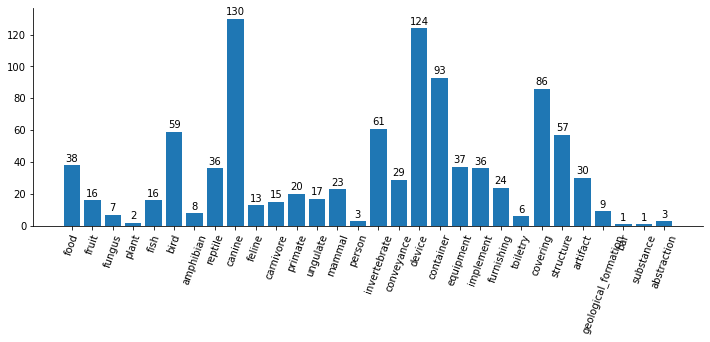

In [10]:
plt.figure(figsize = (12,4))
plt.bar(super_class_index, super_class_number)
plt.xticks(super_class_index, super_class_names, rotation=70)
axis_off(2)
ax = plt.gca()
for index, number in zip(super_class_index, super_class_number):
    ax.text(index, number+1, number, ha='center', va='bottom')
plt.show()

### 4. Roi mean pattern
this step we convert our voxel level data into roi level,
we first see some basic statistics of each roi,
like how many voxels does each roi owns in each hemisphere

In [14]:
atlas = sio.loadmat(pjoin(Analysis_path, atlasfile))['glasser_MMP'].reshape(-1)
# padding to dim 91282
atlas = np.pad(atlas, (0, 91282-len(atlas)), 'constant', constant_values=(0,0))
# load roi names
atlas_df = pd.read_csv(pjoin(Analysis_path, atlas_namefile))
roi_names = [_.split('_')[1] for _ in list(atlas_df.iloc[:,0].values)]

L_roi_voxels = [np.sum(atlas == _+1) for _ in range(180)]
R_roi_voxels = [np.sum(atlas == _+181) for _ in range(180)]
# plt.figure(figsize=(36,8))
# plt.bar(list(range(180)), roi_voxels)
# plt.xticks(list(range(180)), roi_names, rotation=70)
# ax = plt.gca()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for index, number in zip(list(range(180)), roi_voxels):
#     ax.text(index, number+1, number, ha='center', va='bottom')
# plt.show()
print('left  {:8s} has the most voxel number of  {:4d}'.format(roi_names[np.argmax(L_roi_voxels)], np.max(L_roi_voxels)))
print('right {:8s} has the most voxel number of  {:4d}'.format(roi_names[np.argmax(R_roi_voxels)], np.max(R_roi_voxels)))
print('left  {:8s} has the least voxel number of {:4d}'.format(roi_names[np.argmin(L_roi_voxels)], np.min(L_roi_voxels)))
print('right {:8s} has the least voxel number of {:4d}'.format(roi_names[np.argmin(R_roi_voxels)], np.min(R_roi_voxels)))

left  4        has the most voxel number of   825
right V1       has the most voxel number of   841
left  LO2      has the least voxel number of   32
right LO1      has the least voxel number of   44


we then convert our voxel data into roi data

In [4]:

# read the whole data
%time data = [sio.loadmat(pjoin(Analysis_path, 'imagenet_decoding', \
    '_'.join([_,'imagenet-response.mat'])))['response']\
     for _ in ['sub-core02', 'sub-core03']]


CPU times: user 489 ms, sys: 3.54 s, total: 4.03 s
Wall time: 27.8 s


In [33]:
# compute the mean pattern
for subject, vox_data in zip(['sub-core02', 'sub-core03'], data):
    mean_pattern = []
    for _ in range(360):
        roi_index = _ + 1
        roi_mask = atlas==roi_index
        mean_pattern.append(vox_data[:, roi_mask].mean(axis=1))
    mean_pattern = np.vstack(tuple(mean_pattern)).transpose()
    np.save(pjoin(Analysis_path, 'imagenet_decoding', '_'.join([subject, 'roi-mean-pattern.npy'])), mean_pattern) 


In [35]:
# check data
subj = choice(subjects)
mean_pattern = np.load(pjoin(Analysis_path, 'imagenet_decoding', '_'.join([subj, 'roi-mean-pattern.npy'])))
mean_pattern.shape

(4000, 360)

In [36]:
import time
print('Time stamp:')
print(time.strftime('%Y-%m-%d %H:%M:%S'))

Time stamp:
2021-05-30 23:19:40


## Stage 2 Data Inspection
### 1. load our roi data(x) and the label(y)

In [11]:
subjects = ['sub-core02', 'sub-core03']
# first load the roi_data of both subjects into a list
roi_data_path = [pjoin(Analysis_path, 'imagenet_decoding', '_'.join([sub, 'roi-mean-pattern.npy'])) for sub in subjects]
roi_data = [np.load(data_path) for data_path in roi_data_path]
# then we load the label codition of both subjects 
label_path = [pjoin(Analysis_path, 'imagenet_decoding', '_'.join([sub, 'imagenet-label.npy'])) for sub in subjects]
label = [np.load(data_path) for data_path in label_path]
# super calss names
with open(pjoin(Analysis_path, 'superclassinfo.json'), 'r') as f:
    super_class_info = json.load(f)
super_class_name = ["%d.%s" % (_[0], _[1]) for _ in super_class_info['info']]

### 2. description analysis of label data
we first visualize the differences histogram between two example runs in subjets

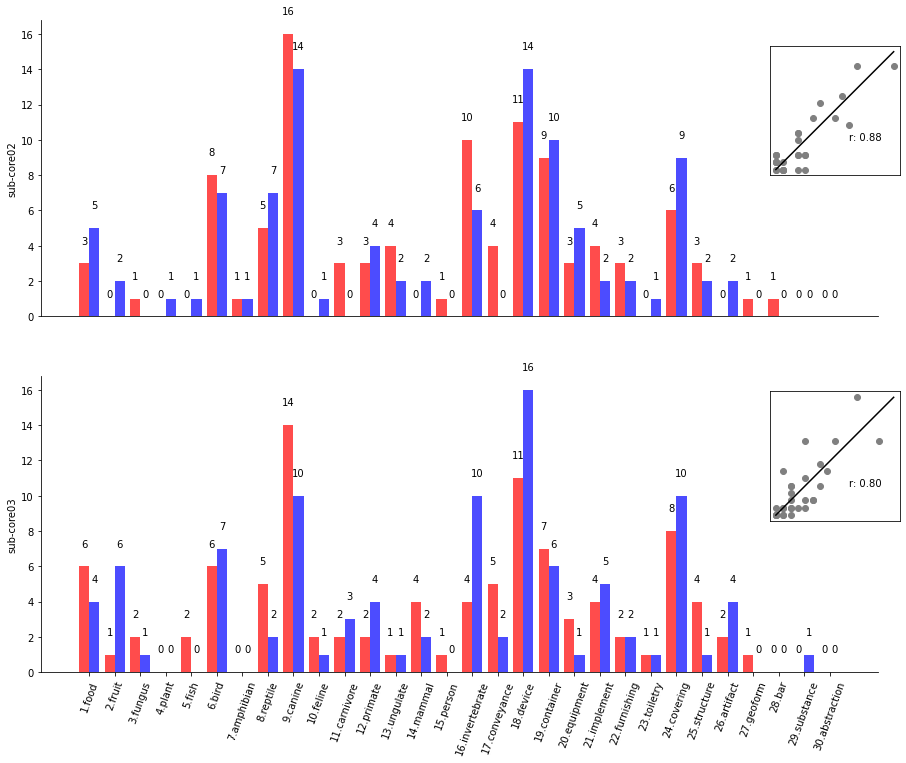

In [18]:
x_1 = 2*np.linspace(0,29,30)
x_2 = x_1 + 0.8
lbwh = [[0.8,0.7, 0.12, 0.15],[0.8,0.3, 0.12, 0.15]]
plt.figure(figsize=(15,12))
# 
for sub, index in zip(subjects, [0,1]):
    plt.subplot(2,1,index+1)
    y_1 = [ np.sum(label[index][0:100]==_+1) for _ in range(30) ]
    y_2 = [ np.sum(label[index][200:300]==_+1) for _ in range(30) ]

    plt.bar(x_1, y_1, color='r', alpha=0.7)
    plt.bar(x_2, y_2, color='b', alpha=0.7)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for x, y, a, b in zip(x_1, y_1, x_2, y_2):
        ax.text(x, y+1, y, ha='center', va='bottom')
        ax.text(a, b+1, b, ha='center', va='bottom')
    plt.ylabel(sub)
    if index==0:
        plt.xticks([])
    else:
        plt.xticks(0.5*(x_1 + x_2), super_class_name, rotation=70)
    # inside scatter
    fig = plt.gcf()
    
    ax1 = fig.add_axes(lbwh[index])
    ax1.scatter(y_1, y_2, c='gray')
    ax1.plot([0, 16], [0, 16],c='black')
    ax1.text(10, 4, 'r: %.2f' % np.corrcoef(y_1,y_2)[0,1])
    ax1.axis('equal')
    ax1.set_xticks([])
    ax1.set_yticks([])

plt.show()

we then draw the **condition correlation matrix** between each pairwise run

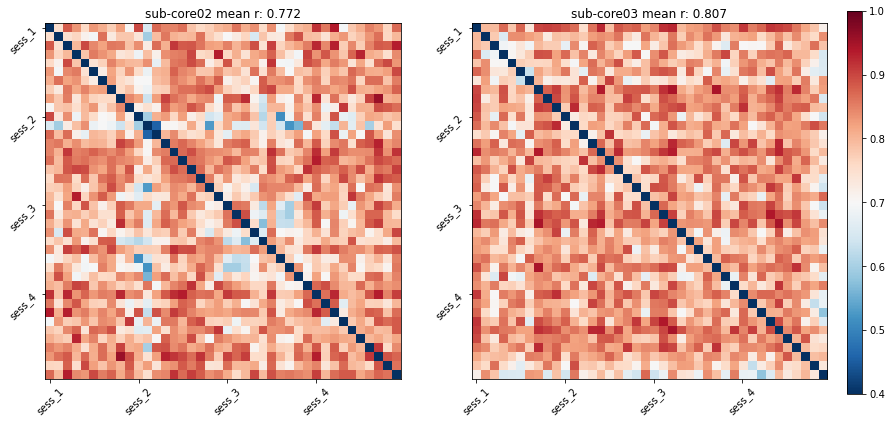

In [19]:
plt.figure(figsize=(14, 7))
run_label_hist = []
for sub, index in zip(subjects, [0,1]):
    plt.subplot(1,2,index+1)   
    # reshape label data & caculate the number for each index
    run_label = label[index].reshape(40,100)
    label_counts = np.vstack(tuple([(run_label==_+1).sum(axis=1) for _ in range(30)])).transpose()
    run_label_hist.append(label_counts)
    # compute correlation
    corr_matrix = np.corrcoef(label_counts)
    # set zero into the diag
    row, col = np.diag_indices_from(corr_matrix)
    corr_matrix[row, col] = 0
    mean_r = np.mean(corr_matrix[np.tri(corr_matrix.shape[0], corr_matrix.shape[1], k=-1).astype('int8')])
    # imshow
    handle = plt.imshow(corr_matrix, cmap='RdBu_r', vmin=0.4, vmax=1)
    plt.xticks([0, 10, 20, 30],["sess_%d" % (d+1) for d in range(4)], rotation=45)
    plt.yticks([0, 10, 20, 30],["sess_%d" % (d+1) for d in range(4)], rotation=45)
    plt.title('%s mean r: %.3f' % (sub, mean_r))
# 获取当前fig，调整subplots，留下0.1给colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.9)
l,b,w = 0.92, 0.12, 0.015
h = 1-2*b 
#对应 l,b,w,h；设置colorbar位置；
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(handle, cax=cbar_ax)
plt.show()

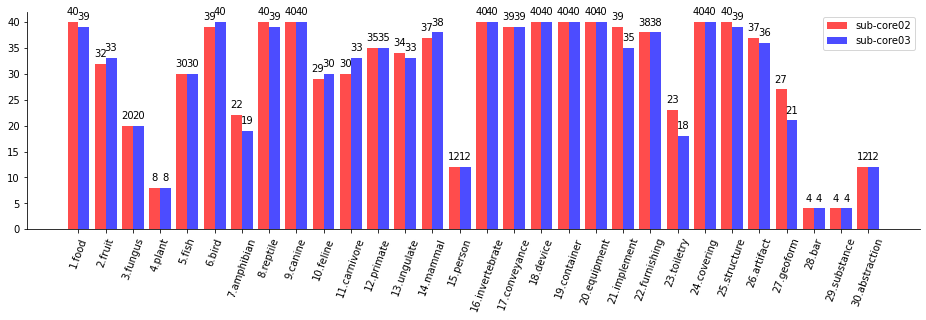

In [20]:
x_1 = 2*np.arange(30)
freq_1 = (run_label_hist[0] != 0).sum(axis=0)
x_2 = x_1 + 0.8
freq_2 = (run_label_hist[1] != 0).sum(axis=0)

plt.figure(figsize=(16,4))
plt.bar(x_1, freq_1, label='sub-core02', color='r', alpha=0.7)
plt.bar(x_2, freq_2, label='sub-core03', color='b', alpha=0.7)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for x, y, a, b in zip(x_1, freq_1, x_2, freq_2):
    ax.text(x, y+1, y, ha='center', va='bottom')
    ax.text(a, b+1, b, ha='center', va='bottom')
plt.xticks(0.5*(x_1 + x_2), super_class_name, rotation=70)
plt.legend()
plt.show()

so far we have seen:  
    1. each run has slightly different superclass condition, which may contribute to the variance of mean response of runs;  
    2. conditions of runs have relatively mighty pair-wise correlation;  
    3. conditions repeated in every run may be ideal choices to decode

### 3. description analysis of roi response data

In [21]:
# reshape into 40 runs roi mean pattern
run_roi_pattern = [roi_data[index].reshape((40,100,360)) for index in [0,1]]

we may first check the total ***mean of all rois & all conditions*** in each run

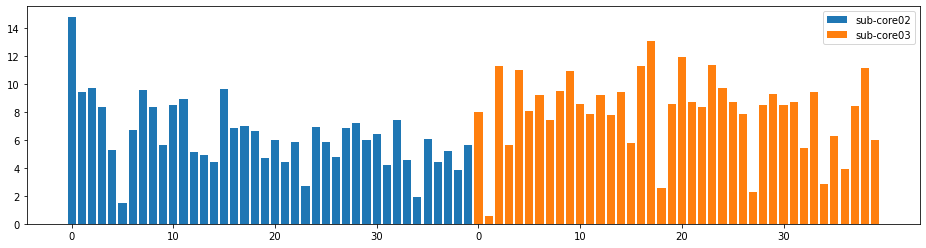

In [14]:
# 
plt.figure(figsize=(16,4))
for sub, index in zip(subjects, [0,1]):
    run_means = run_roi_pattern[index].mean(axis=(1,2))
    plt.bar(np.arange(40)+40*index, run_means, label=sub)
plt.legend()
plt.xticks([10*i for i in range(8)], [10*i for i in range(4)]*2)
plt.show()

then we select two runs to see the roi pattern among all conditions

In [23]:
index = 0
run_1 = run_roi_pattern[index][0,:,:]

in **run one**, each condition have mean roi pattern (1 X 360)  
the similarity matrix (pearson's corralation) between class is ploted below:



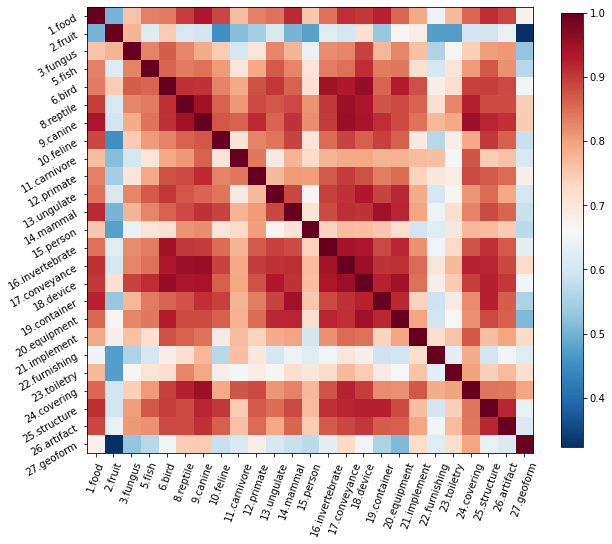

In [24]:
superclass_run1_roi = np.vstack([run_1[run_label[0,:]==_+1].mean(axis=0) for _ in range(30) if any(run_label[0,:]==_+1)])
superclass_run1 = [super_class_name[_] for _ in range(30) if any(run_label[0,:]==_+1)]

corr_matrix=np.corrcoef(superclass_run1_roi)
# set zero into the diag
# row, col = np.diag_indices_from(corr_matrix)
# corr_matrix[row, col] = corr_matrix[np.tri(30,30,-1).astype('int8')].mean()

plt.figure(figsize=(10,10))
plt.imshow(corr_matrix, cmap='RdBu_r')
plt.xticks(list(range(len(superclass_run1))), superclass_run1, rotation=70)
plt.yticks(list(range(len(superclass_run1))), superclass_run1, rotation=30)
plt.colorbar(shrink=0.8)
plt.show()


we can also compare the similarity between two hemishperes:   
matrix show the pearson's correlation  
scatter show the diag of matrix in detail 

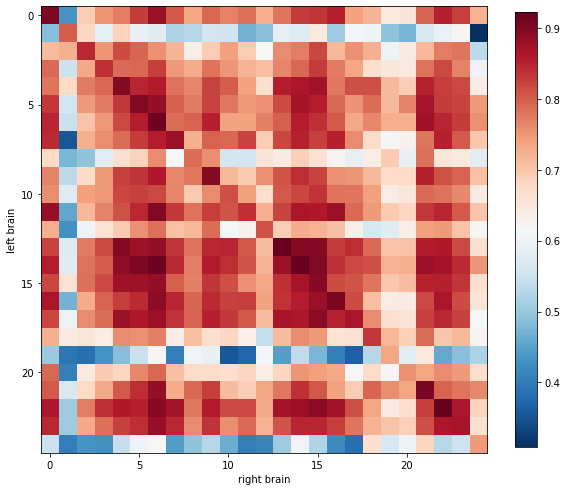

In [14]:
L_superclass_run1_roi = superclass_run1_roi[:, 0:180]
R_superclass_run1_roi = superclass_run1_roi[:, 180:360]
corr_matrix = np.corrcoef(L_superclass_run1_roi, R_superclass_run1_roi)[0:25, 25:50]
plt.figure(figsize=(10,10))
plt.imshow(corr_matrix, cmap='RdBu_r')
plt.colorbar(shrink=0.8)
plt.xlabel('right brain')
plt.ylabel('left brain')

plt.show()


In [15]:
print(np.diag(corr_matrix))

[0.9025926  0.80076923 0.84615954 0.83914925 0.89789377 0.90044824
 0.91297584 0.88024763 0.78660791 0.89631517 0.81219419 0.83864481
 0.81089529 0.9203614  0.92121177 0.89421528 0.90527089 0.86680783
 0.83247495 0.7364747  0.75490521 0.90580689 0.92228911 0.86879685
 0.74731708]


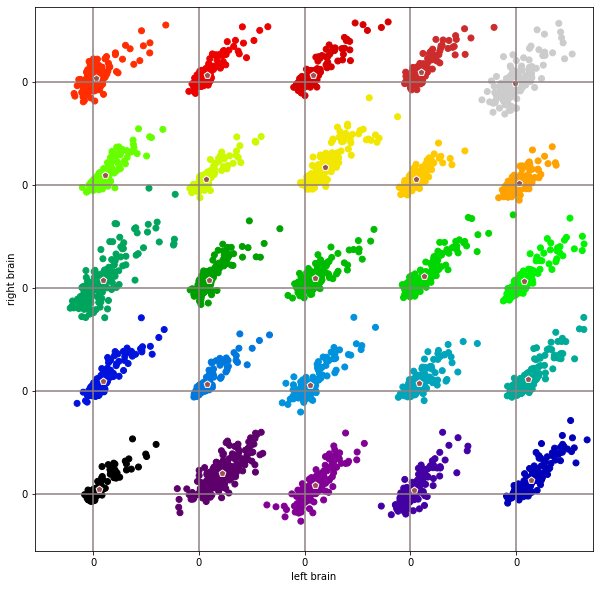

In [16]:
plt.figure(figsize=(10,10))
# to separate each condition an arithmetic sequence is created fror viusalization
t_L_superclass_run1_roi = L_superclass_run1_roi + np.tile(180*np.arange(5), 5).reshape((25,1))
t_R_superclass_run1_roi = R_superclass_run1_roi + 180*np.arange(5).repeat(5).reshape((25,1))
center_line = [180*_ for _ in np.arange(5)]
# conditions label
conditions = []
for i in range(25):
    temp = [i+1]*180
    conditions = conditions+temp
# means
L_means = t_L_superclass_run1_roi.mean(axis=1)
R_means = t_R_superclass_run1_roi.mean(axis=1)
# plot
plt.scatter(t_L_superclass_run1_roi.flatten(), t_R_superclass_run1_roi.flatten(), c=conditions, cmap='nipy_spectral')
# plt.colorbar()
for center in center_line:
    plt.plot([center, center], [-100, 900], color='#8e7f7f', lw=1.5)
    plt.plot([-100,900], [center,center],color='#8e7f7f', lw=1.5)#
plt.scatter(L_means, R_means, s=50, color='#9b5151', marker='p', edgecolors='white')#8e7f7f f8f1f1 ece2e1
plt.xlim([-100, 850])
plt.ylim([-100, 850])
plt.xticks(center_line, 5*[0])
plt.yticks(center_line, 5*[0])
plt.xlabel('left brain')
plt.ylabel('right brain')
plt.show()

here we turn to one seesion, to see that for each condition how is their run consisitency


In [25]:
# collect the run_superclass_roi without standarization
run_superclass_roi, mean_corr = [], []
for sub, index in zip(subjects, [0, 1]):
    # 
    superclass_roi = [] # run*superclass*roi
    for run_idx in range(10):
        cur_run = run_roi_pattern[index][run_idx,:,:]
        superclass_run_roi = []
        for _ in range(30):
            if any(run_label[0,:]==_+1):
                superclass_run_roi.append(cur_run[run_label[0,:]==_+1].mean(axis=0))
            else:
                superclass_run_roi.append(np.zeros((360,)))
        superclass_run_roi = np.vstack(tuple(superclass_run_roi))
        superclass_roi.append(superclass_run_roi)
    superclass_roi = np.stack(tuple(superclass_roi))
    run_superclass_roi.append(superclass_roi)
    # 
    print('==============',sub,'==================')
    for superclass in range(30):
        runs_roi = superclass_roi[:, superclass, :]
        corr_matrix = np.corrcoef(runs_roi)
        # print('%2d' % (superclass+1), end='.')
        print('%18s' % (super_class_name[superclass]),end=': ')
        print(np.mean(corr_matrix[np.tril(corr_matrix, -1)!=0]))
        mean_corr.append(np.mean(corr_matrix[np.tril(corr_matrix, -1)!=0]))

============== sub-core02 ==================
            1.food: 0.7587400645314495
           2.fruit: 0.2474789356732567
          3.fungus: 0.4173829304380033
           4.plant: nan
            5.fish: 0.585550673914001
            6.bird: 0.6741426628091173
       7.amphibian: nan
         8.reptile: 0.7625752160693676
          9.canine: 0.868341896401992
         10.feline: 0.6306054338722644
      11.carnivore: 0.46999616537017896
        12.primate: 0.621938761057059
       13.ungulate: 0.4536634921520278
         14.mammal: 0.7380601134459808
         15.person: 0.5900477130830923
   16.invertebrate: 0.7291495313781722
     17.conveyance: 0.7457932206098327
         18.device: 0.8379866461257496
      19.container: 0.7530442212826549
      20.equipment: 0.6764374566157743
      21.implement: 0.7022385909313165
     22.furnishing: 0.60355495616054
       23.toiletry: 0.34738607849242936
       24.covering: 0.8338101237405524
      25.structure: 0.7060469188524598
       26.art

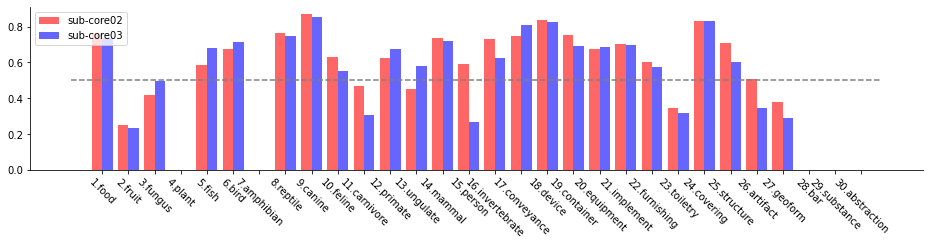

In [21]:
plt.figure(figsize=(16,3))
plt.bar(x_1, mean_corr[0:30], color='r', alpha=0.6, label='sub-core02')
plt.bar(x_2, mean_corr[30:60], color='b', alpha=0.6, label='sub-core03')
plt.xticks(0.5 * (x_1 + x_2), super_class_name, rotation=-45)
plt.legend()
plt.plot([-2, 60], [0.5, 0.5], ls='--', color='gray', lw=1.5)
axis_off(2)
plt.show()

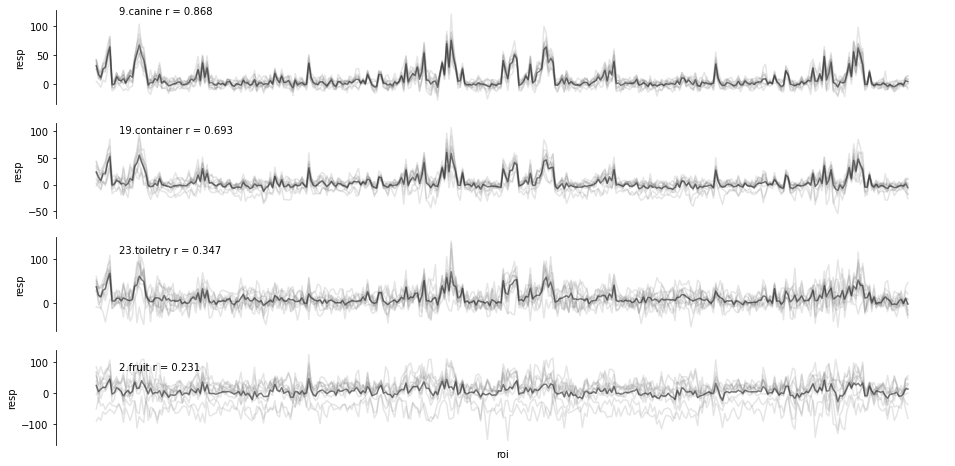

In [12]:
instance_index = [8, 18, 22, 1] # carnivore, primate, fungus fruit
superclass_roi = run_superclass_roi[0] # sub-core02
instances = [superclass_roi[:,_,:] for _ in instance_index]
plt.figure(figsize=(16,8))
for index, data in zip(list(range(len(instances))), instances):
    plt.subplot(4,1,index+1)
    plt.plot(data.transpose(), color='gray', alpha=0.2)
    plt.plot(data.transpose().mean(axis=1), color='black', lw=1.5,alpha=0.5)
    plt.text(10, 1.6*np.max(data.transpose().mean(axis=1)), '%s r = %.3f' % (super_class_name[instance_index[index]], mean_corr[30*(index%2)+instance_index[index]]))
    plt.ylabel('resp')
    axis_off(3)
plt.xlabel('roi')
plt.show()

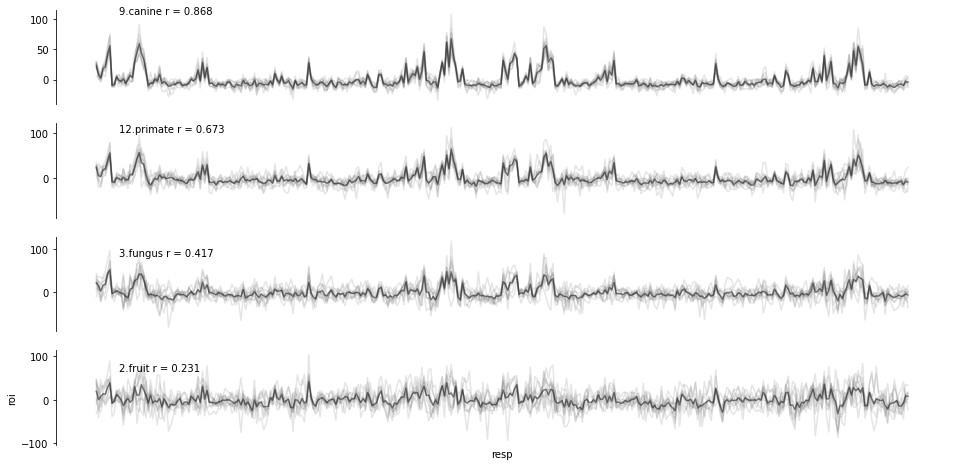

In [101]:
instance_index = [8, 11, 2, 1] # carnivore, primate, fungus fruit
superclass_roi = run_superclass_roi[0] # sub-core02
instances = [superclass_roi[:,_,:] for _ in instance_index]
plt.figure(figsize=(16,8))
for index, data in zip(list(range(len(instances))), instances):
    plt.subplot(4,1,index+1)
    # let's see what if we minus the mean spatial pattern
    data = data - data.mean(axis=1).reshape((10,1))
    plt.plot(data.transpose(), color='gray', alpha=0.2)
    plt.plot(data.transpose().mean(axis=1), color='black', lw=1.5,alpha=0.5)
    plt.text(10, 1.6*np.max(data.transpose().mean(axis=1)), '%s r = %.3f' % (super_class_name[instance_index[index]], mean_corr[30*(index%2)+instance_index[index]]))
    axis_off(3)
plt.xlabel('resp')
plt.ylabel('roi')
plt.show()

what if we remove the mean of run for poor-correlation category  
and we expect that it doesn't matter at all

0.2474789356732567


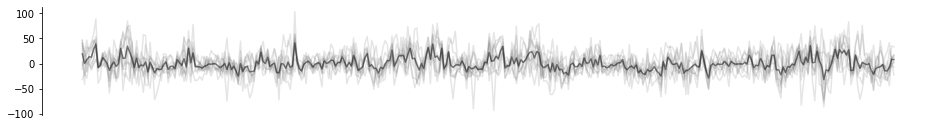

In [102]:
data = superclass_roi[:,1,:] # fruit
data = data - data.mean(axis=1).reshape((10,1))
plt.figure(figsize=(16,2))
plt.plot(data.transpose(), color='gray', alpha=0.2)
plt.plot(data.transpose().mean(axis=1), color='black', lw=1.5,alpha=0.5)
axis_off(3)
print(np.mean(np.corrcoef(data)[np.tril(np.corrcoef(data), -1) != 0]))


next we concern the relation between correlation value with superclass numbers 

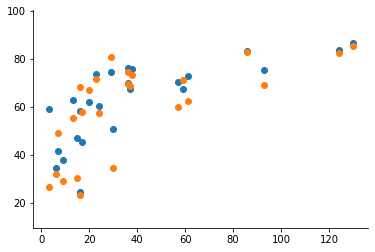

In [94]:
# super calss number
with open(pjoin(Analysis_path, 'superclassinfo.json'), 'r') as f:
    super_class_info = json.load(f)
super_class_number = [_[2] for _ in super_class_info['info']]
plt.scatter(super_class_number, 100*np.array(mean_corr[0:30]))
plt.scatter(super_class_number, 100*np.array(mean_corr[30:60]))
plt.axis('equal')
axis_off(2)
plt.show()

we here consider the inluence of standarization

In [28]:
# collect the run_superclass_roi with standarization
st_run_superclass_roi, st_mean_corr = [], []

for sub, index in zip(subjects, [0, 1]):
    #
    st_run_roi_pattern = np.zeros_like(run_roi_pattern[index])
    for _ in range(40): 
        st_run_roi_pattern[_,:,:] = zscore(run_roi_pattern[index][_,:,:]) #run_roi_pattern[index][_,:,:] - run_roi_pattern[index][_,:,:].mean(axis=0) 
    superclass_roi = [] # run*superclass*roi
    for run_idx in range(10):
        cur_run = st_run_roi_pattern[run_idx,:,:]
        superclass_run_roi = []
        for _ in range(30):
            if any(run_label[0,:]==_+1):
                superclass_run_roi.append(cur_run[run_label[0,:]==_+1].mean(axis=0))
            else:
                superclass_run_roi.append(np.zeros((360,)))
        superclass_run_roi = np.vstack(tuple(superclass_run_roi))
        superclass_roi.append(superclass_run_roi)
    superclass_roi = np.stack(tuple(superclass_roi))
    st_run_superclass_roi.append(superclass_roi)
    # 
    print('=====st=======',sub,'======st==========')
    for superclass in range(30):
        runs_roi = superclass_roi[:, superclass, :]
        corr_matrix = np.corrcoef(runs_roi)
        # print('%2d' % (superclass+1), end='.')
        print('%18s' % (super_class_name[superclass]),end=': ')
        print(np.mean(corr_matrix[np.tril(corr_matrix, -1)!=0]))
        st_mean_corr.append(np.mean(corr_matrix[np.tril(corr_matrix, -1)!=0]))

=====st======= sub-core02 ======st==========
            1.food: -0.02407746523893794
           2.fruit: 0.09057611045938056
          3.fungus: 0.025262394178258745
           4.plant: nan
            5.fish: 0.021199995929691184
            6.bird: -0.033990480234589455
       7.amphibian: nan
         8.reptile: 0.025327584044210507
          9.canine: 0.020576190199053688
         10.feline: 0.030342656077505994
      11.carnivore: 0.0375424909607628
        12.primate: 0.021980553580484417
       13.ungulate: 0.05263188026975074
         14.mammal: 0.0917617507059443
         15.person: -0.014420167473934329
   16.invertebrate: 0.013718865979862209
     17.conveyance: -0.020146973517401287
         18.device: -0.011084669383580648
      19.container: 0.03650017566141237
      20.equipment: 0.06930863691110947
      21.implement: 0.037216857644398874
     22.furnishing: -0.0053117659502746346
       23.toiletry: 0.003885093676243365
       24.covering: 0.0544005543241557
      25.

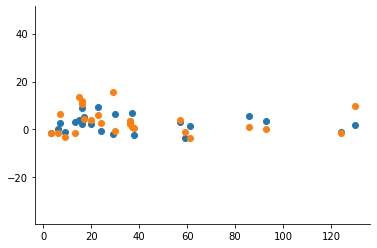

In [133]:
# super calss number
with open(pjoin(Analysis_path, 'superclassinfo.json'), 'r') as f:
    super_class_info = json.load(f)
super_class_number = [_[2] for _ in super_class_info['info']]
plt.scatter(super_class_number, 100*np.array(st_mean_corr[0:30]))
plt.scatter(super_class_number, 100*np.array(st_mean_corr[30:60]))
plt.axis('equal')
axis_off(2)
plt.show()

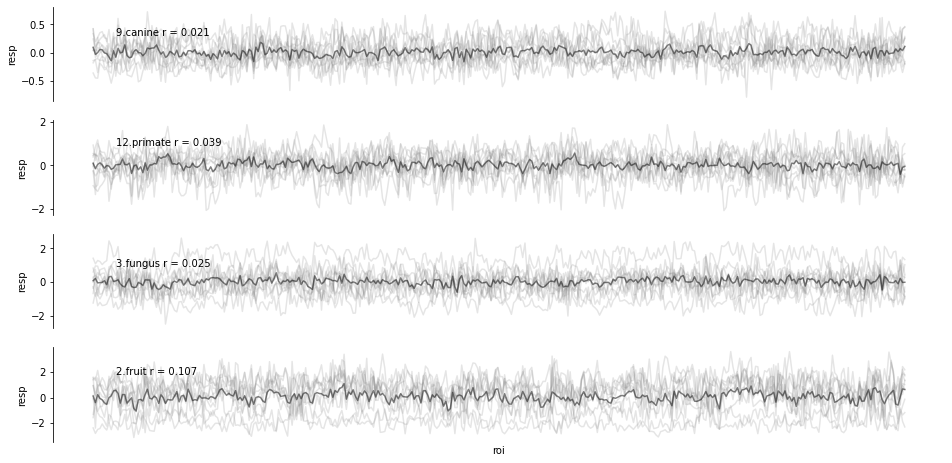

In [134]:
instance_index = [8, 11, 2, 1] # carnivore, primate, fungus fruit
superclass_roi = st_run_superclass_roi[0] # sub-core02
instances = [superclass_roi[:,_,:] for _ in instance_index]
plt.figure(figsize=(16,8))
for index, data in zip(list(range(len(instances))), instances):
    plt.subplot(4,1,index+1)
    plt.plot(data.transpose(), color='gray', alpha=0.2)
    plt.plot(data.transpose().mean(axis=1), color='black', lw=1.5,alpha=0.5)
    plt.text(10, 1.6*np.max(data.transpose().mean(axis=1)), '%s r = %.3f' % (super_class_name[instance_index[index]], st_mean_corr[30*(index%2)+instance_index[index]]))
    plt.ylabel('resp')
    axis_off(3)
plt.xlabel('roi')
plt.show()

In [95]:
print('sub-core02\n', np.argsort(mean_corr[0:30])[::-1][5:])
print('sub-core03\n', np.argsort(mean_corr[30:60])[::-1][5:])
sub_2_top = np.array(super_class_name)[np.nan_to_num(np.array(mean_corr[0:30]), 0) >= 0.6]
sub_3_top = np.array(super_class_name)[np.nan_to_num(np.array(mean_corr[30:60]), 0) >= 0.6]
print(sub_2_top)
print(sub_3_top)
set(list(sub_2_top)) & set(list(sub_3_top))

sub-core02
 [ 8 17 23  7  0 18 16 13 15 24 20 19  5  9 11 21 14  4 25 10 12  2 26 22
  1]
sub-core03
 [ 8 23 17 16  7  0 13  5 20 18 19  4 11 15 24 12 21  9  2 25 22 10 26 14
  1]
['1.food' '6.bird' '8.reptile' '9.canine' '10.feline' '12.primate'
 '14.mammal' '16.invertebrate' '17.conveyance' '18.device' '19.container'
 '20.equipment' '21.implement' '22.furnishing' '24.covering'
 '25.structure']
['1.food' '5.fish' '6.bird' '8.reptile' '9.canine' '12.primate'
 '14.mammal' '16.invertebrate' '17.conveyance' '18.device' '19.container'
 '20.equipment' '21.implement' '24.covering' '25.structure']


{'1.food',
 '12.primate',
 '14.mammal',
 '16.invertebrate',
 '17.conveyance',
 '18.device',
 '19.container',
 '20.equipment',
 '21.implement',
 '24.covering',
 '25.structure',
 '6.bird',
 '8.reptile',
 '9.canine'}

We select the above 14 classes 

In [35]:
selected_super_calsses = [1, 6, 8, 9, 12, 14, 16, 17, 18, 19, 20, 21, 24, 25]
# raw data: run_superclass_roi | standarized: st_run_superclass_roi
selected_run_roi = [st_run_superclass_roi[_][:, np.array(selected_super_calsses)-1, :] for _ in [0,1]]

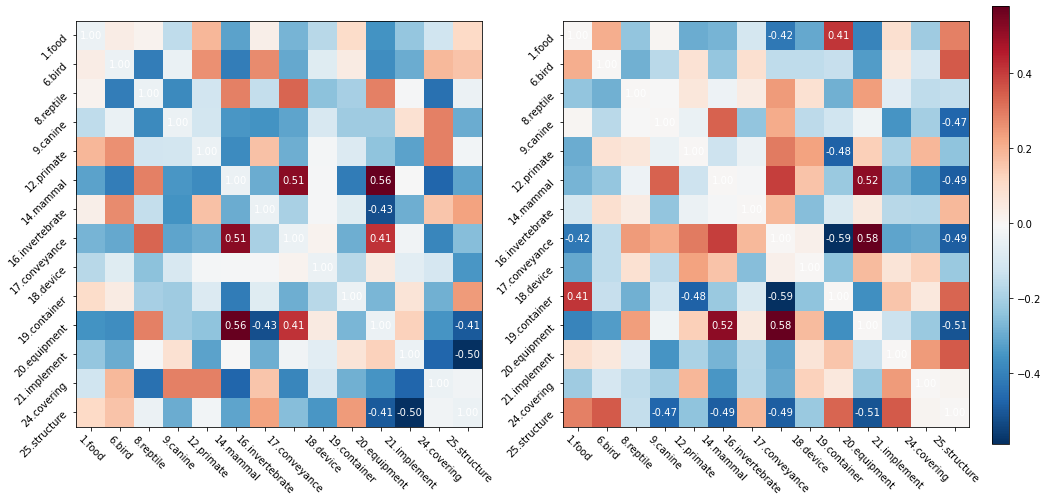

In [36]:
# 
plt.figure(figsize=(16,8))
for sub, index in zip(subjects, [0, 1]):
    plt.subplot(1,2,index+1)
    sub_roi = selected_run_roi[index][:, :, :].mean(axis=0)
    corr_matrix = np.corrcoef(sub_roi)
    
    handle = plt.imshow(corr_matrix-np.eye(len(corr_matrix)), cmap='RdBu_r') # vmin=-1, vmax=1,
    plt.xticks(list(range(len(selected_super_calsses))), [super_class_name[_-1] for _ in selected_super_calsses], rotation=-45)
    plt.yticks(list(range(len(selected_super_calsses))), [super_class_name[_-1] for _ in selected_super_calsses], rotation=45)
    # diagmean_cm = corr_matrix
    # row, col = np.diag_indices_from(diagmean_cm)
    # diagmean_cm[row, col] = diagmean_cm[np.tri(14,14,-1).astype('int8')].mean()
    # print('{%s} max {%.3f} min {%.3f}' % (sub, np.nanmax(diagmean_cm), np.nanmin(diagmean_cm)))
    # for _, __ in zip([super_class_name[_-1] for _ in selected_super_calsses], list(range(len(selected_super_calsses)))):
    #     print('%16s: %.3f' % (_, diagmean_cm.mean(axis=0)[__]))

    ind_array = np.arange(len(selected_super_calsses))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = corr_matrix[y_val][x_val]
        if np.abs(c) >0.4:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='white', fontsize=10, va='center', ha='center')

# 获取当前fig，调整subplots，留下0.1给colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.9)
l,b,w = 0.92, 0.12, 0.015
h = 1-2*b 
#对应 l,b,w,h；设置colorbar位置；
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(handle, cax=cbar_ax, shrink=0.7)
plt.show()

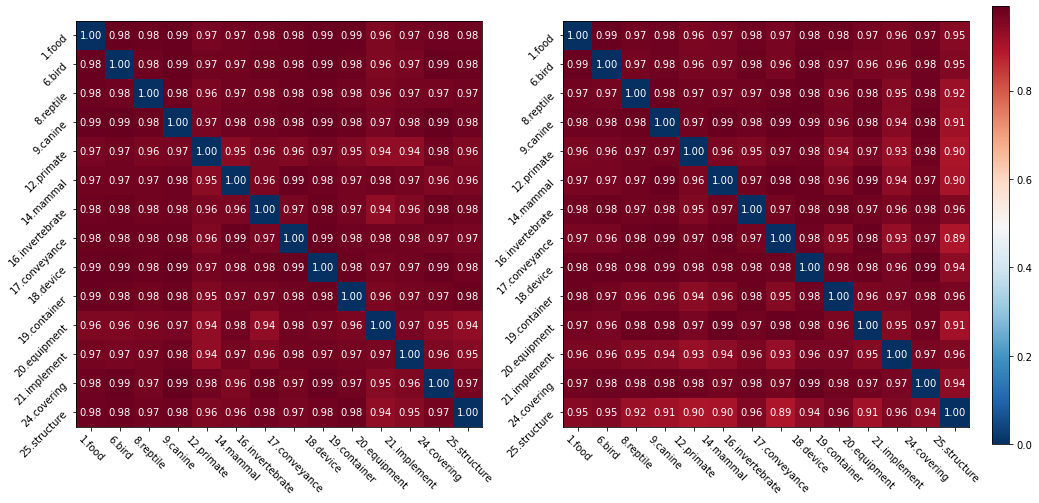

In [37]:
selected_run_roi = [run_superclass_roi[_][:, np.array(selected_super_calsses)-1, :] for _ in [0,1]]
plt.figure(figsize=(16,8))
for sub, index in zip(subjects, [0, 1]):
    plt.subplot(1,2,index+1)
    sub_roi = selected_run_roi[index][:, :, :].mean(axis=0)
    corr_matrix = np.corrcoef(sub_roi)
    
    handle = plt.imshow(corr_matrix-np.eye(len(corr_matrix)), cmap='RdBu_r') # vmin=-1, vmax=1,
    plt.xticks(list(range(len(selected_super_calsses))), [super_class_name[_-1] for _ in selected_super_calsses], rotation=-45)
    plt.yticks(list(range(len(selected_super_calsses))), [super_class_name[_-1] for _ in selected_super_calsses], rotation=45)
    # diagmean_cm = corr_matrix
    # row, col = np.diag_indices_from(diagmean_cm)
    # diagmean_cm[row, col] = diagmean_cm[np.tri(14,14,-1).astype('int8')].mean()
    # print('{%s} max {%.3f} min {%.3f}' % (sub, np.nanmax(diagmean_cm), np.nanmin(diagmean_cm)))
    # for _, __ in zip([super_class_name[_-1] for _ in selected_super_calsses], list(range(len(selected_super_calsses)))):
    #     print('%16s: %.3f' % (_, diagmean_cm.mean(axis=0)[__]))

    ind_array = np.arange(len(selected_super_calsses))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = corr_matrix[y_val][x_val]
        if np.abs(c) >0.4:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='white', fontsize=10, va='center', ha='center')

# 获取当前fig，调整subplots，留下0.1给colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.9)
l,b,w = 0.92, 0.12, 0.015
h = 1-2*b 
#对应 l,b,w,h；设置colorbar位置；
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(handle, cax=cbar_ax, shrink=0.7)
plt.show()


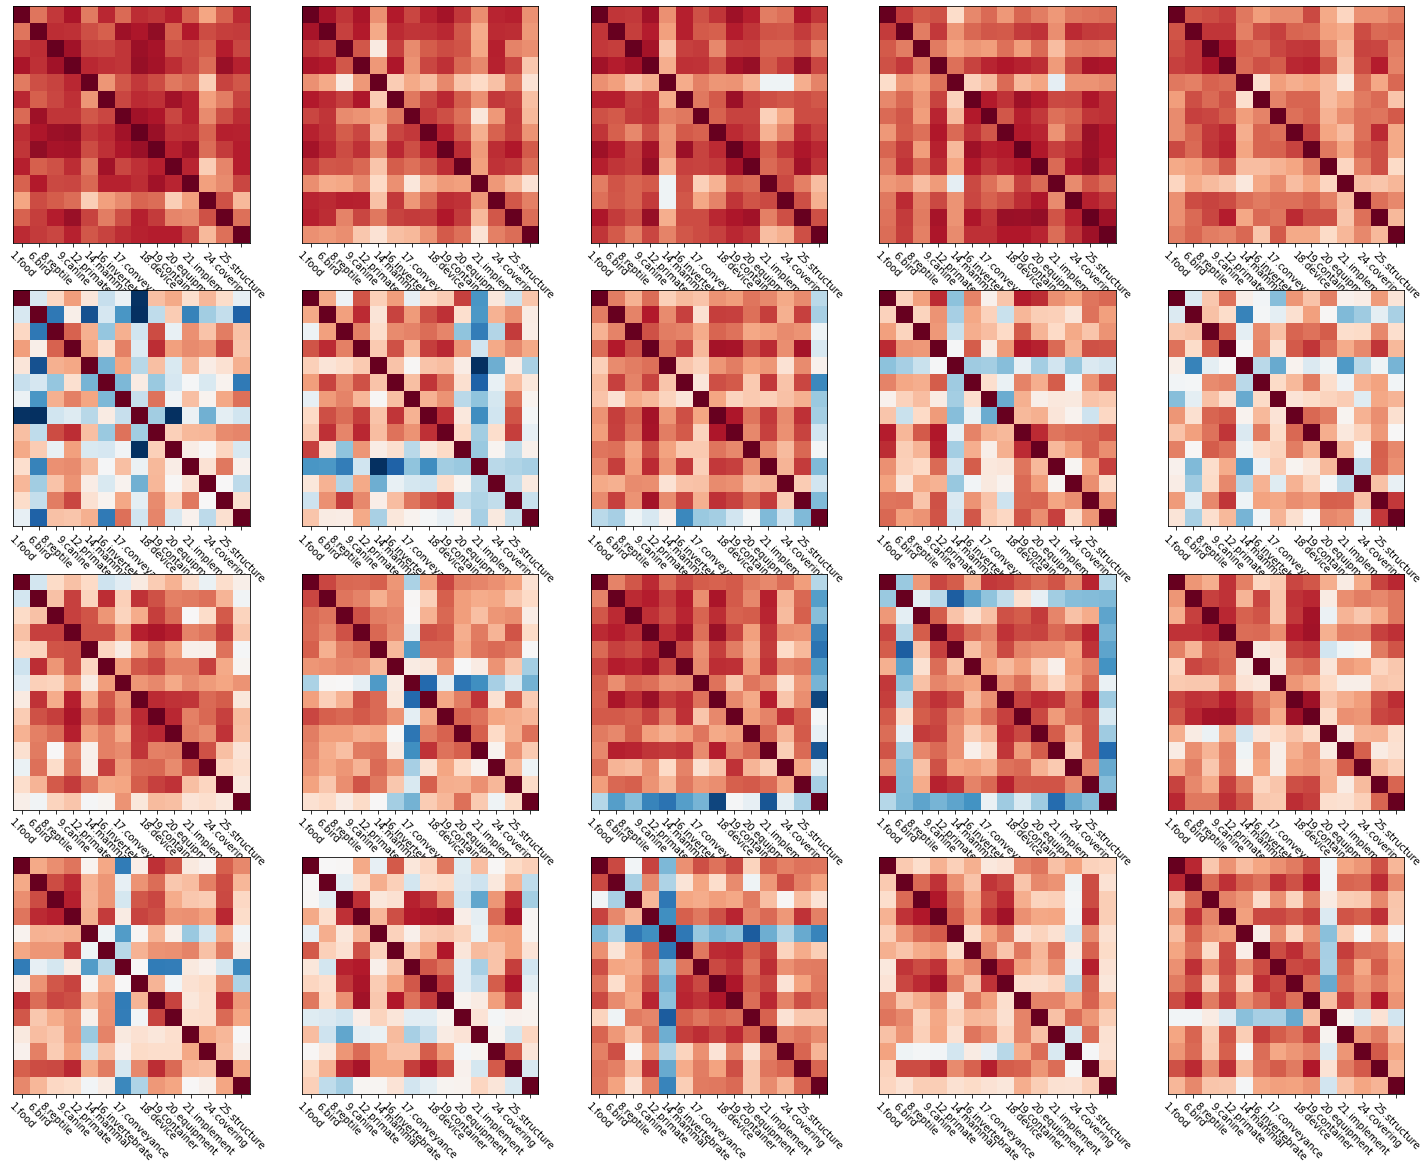

In [98]:
plt.figure(figsize=(25,20))
for sub, index in zip(subjects, [0, 1]):
    for run in range(10):
        plt.subplot(4,5,run+1+10*index)
        sub_run_roi = selected_run_roi[index][run, :, :]
        corr_matrix = np.corrcoef(sub_run_roi)
        plt.imshow(corr_matrix, vmin=0.3, vmax=1, cmap='RdBu_r')
        plt.xticks(list(range(len(selected_super_calsses))), [super_class_name[_-1] for _ in selected_super_calsses], rotation=-45)
        plt.yticks([])
        # 
        # diagmean_cm = corr_matrix
        # row, col = np.diag_indices_from(diagmean_cm)
        # diagmean_cm[row, col] = diagmean_cm[np.tri(14,14,-1).astype('int8')].mean()
        # print('run {%02d} max {%.3f} min {%.3f}' % (run+1, np.nanmax(diagmean_cm), np.nanmin(diagmean_cm)))
plt.show()

In [99]:
3%2

1

we standarized the 

In [109]:
index=0
(run_roi_pattern[index][0,:,:] - run_roi_pattern[index][0,:,:].mean(axis=0))/run_roi_pattern[index][0,:,:].std(axis=0)

array([[-0.02653982,  0.45578436, -0.44734708, ...,  0.4874784 ,
         0.12300813, -0.05157675],
       [ 1.10863837, -0.6043207 ,  0.06712792, ...,  0.14856374,
         1.40509246,  1.31008543],
       [-0.99271025, -2.17982429, -1.40463045, ...,  1.56749593,
        -0.43543106, -0.21871795],
       ...,
       [-0.76793317, -0.83185984,  0.17652654, ..., -0.66742644,
         0.88870159,  1.00106868],
       [ 0.57780555,  0.54399099,  0.10218096, ...,  0.36245059,
         0.73565453, -1.05170269],
       [-0.02615742, -0.50524647,  0.90912031, ..., -1.05032348,
         0.7378016 ,  0.95055033]])

In [26]:
from scipy.stats import zscore
zscore(run_roi_pattern[index][0,:,:])

array([[ 2.72046554,  1.85331314,  1.96932925, ...,  0.99806137,
         3.23609694,  0.06859498],
       [ 0.75598497, -0.11414326, -0.24412129, ...,  0.92494092,
        -0.65921731,  0.78623706],
       [-1.63797644, -2.23637146, -1.02504127, ...,  0.65516986,
         1.7458162 , -1.15815106],
       ...,
       [ 1.4609168 ,  1.13087783,  1.83404096, ..., -0.82733085,
         0.92902918,  1.22995302],
       [-1.72203205, -1.8381065 , -2.6594011 , ..., -1.41500402,
        -1.45900183, -1.5439855 ],
       [-0.0336959 ,  0.04364017, -0.05512851, ..., -0.27693421,
         1.84482218,  0.39077085]])

Below we compute tSNR after ica denoise

In [2]:

imagenet_data_path = '/nfs/s2/userhome/gongzhengxin/nvd/Analysis_results/imagenet_decoding'
data_denoised = np.load(pjoin(imagenet_data_path, 'sub-03_imagenet-response_ica.npy'))
data_raw = sio.loadmat(pjoin(imagenet_data_path, 'sub-core03_imagenet-response.mat'))['response']

In [3]:
data_denoised.shape

(4000, 91282)

In [4]:
data_raw.shape

(4000, 91282)

In [6]:
def tsnr(data):
    mean = data.mean(axis=-1)
    std = data.std(axis=-1)
    return mean/std
tsnr_raw = tsnr(data_raw)
tsnr_denoised = tsnr(data_denoised)

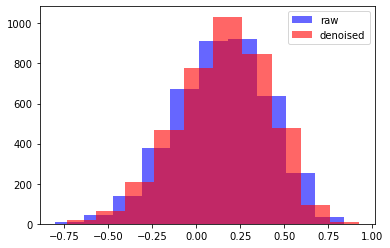

In [7]:
plt.hist(tsnr_raw, color='blue', alpha=0.6, label='raw')
plt.hist(tsnr_denoised, color='red', alpha=0.6, label='denoised')
plt.legend()
plt.show()

In [12]:
tsnr_denoised.mean()

0.1556381637741509

In [9]:
def imagenet_(nifti_dir, save_path, roi_mat=None):
    result_dir = 'MNINonLinear/Results/'
    # --20210331 the following code forget to consider the actual sequence of experiment 
    # --20210406 rewrite to fix the problem, reveal that missing .sort() casue the sequence before was messing
    try:
        # input dirs
        for sub_dir in ['sub-core02']:
            # MNINolinear/Results disposit all the runs data
            _result_path = pjoin(ciftify_dir, sub_dir, result_dir)
            # extract the ImageNet runs
            imagenet_runs = [_ for _ in os.listdir(_result_path) if ('ImageNet' in _) and ('discard' not in _)]
            imagenet_runs.sort() # sort() to be [1 10 2 -- 9]
            # initialize the mapping dict
            stim_resp_map = {}
            # loop run
            for single_run in imagenet_runs:
                print(single_run)
                # collect session number & run number
                ses = int((single_run.split('_')[0]).replace('ses-ImageNet', ''))
                runidx = int(single_run.split('_')[2].replace('run-', ''))
                # prepare .feat/GrayordinatesStats dir
                nii_dir = '{0}'.format(single_run)
                nii_path = pjoin(ciftify_dir, sub_dir, result_dir, nii_dir)
                # loop trial 
                
                nii_file = pjoin(nii_path, '{0}_Atlas.dtseries.nii'.format(single_run))
                dt_data = nib.load(nii_file).get_fdata()
                if roi_mat:
                    # only save roi
                    stim_resp_map[single_run] = np.array(dt_data[:,roi_mat])
                else:
                    stim_resp_map[single_run] = np.array(dt_data)
            # transfer to matrix
            imagenet_data = np.vstack(tuple([stim_resp_map[_] for _ in list(stim_resp_map.keys())]))
            imagenet_data = {'response': imagenet_data}

            return imagenet_data
            # sio.savemat('{}/{}_imagenet-nii.mat'.format(save_path, sub_dir), imagenet_data)
            # save to stimuli_response_maping/ folder


In [3]:
result_dir = '/nfs/s2/userhome/gongzhengxin/workingdir/fMRI/NaturalVisionProject/Analysis'
sub02_denoised = np.load(pjoin(result_dir, 'sub-02_imagnet-nii.npy'))
sub02_raw = np.load()

In [5]:
!